In [1]:
import numpy as np
import matplotlib.pyplot as plt
from solver_linear import Solver, Method
from norms import norm_vec, NormType

plt.style.use("ggplot")

In [2]:
def create_polynomial(coefficients):
    """Создает полиномиальную функцию с заданными коэффициентами"""
    def polynomial(x):
        result = 0
        for i, coef in enumerate(coefficients):
            result += coef * x**i
        return result
    return polynomial

def create_func(coefficients, basis):
    """Создает функцию по данному базису с заданными коэффициентами"""
    def func(x):
        result = 0
        for i, coef in enumerate(coefficients):
            result += coef * basis[i](x)
        return result
    return func

def create_sin_basis(k):
    """Создаем функцию вида sin(k*x), где k - некий коэффициент"""
    def polynomial(x):
        return np.sin(k*x)
    return polynomial

## Алгоритм интерполяции по базису и "опорным" точкам

In [4]:
def calc_A(x_array, basis):
    dim = len(basis)
    # Создаем матрицу, где каждая строка соответствует элементу x_array, а столбцы - значениям базисных функций
    result_matrix = np.zeros((len(x_array), dim))
    for i in range(dim):
        result_matrix[:, i] = basis[i](x_array)
    return result_matrix

def interpolate(x, f, basis=None):
    n = len(x)
    if basis is None:
        # Если не задан базис, то это полиномы степени не выше n
        ed = np.eye(n)
        basis = [create_polynomial(ed[:,i]) for i in range(n)]
    
    # Матрица A для CЛАУ
    A = calc_A(x, basis)
    # Коэффициенты a
    sl = Solver()
    a = sl.solve(A, f[..., None], method=Method.GAUSS_TWO)
    return create_func(a, basis)



### Функция подсчета ошибки
### Ошибка - норма бесконечности

In [5]:
def error(f, F, x):
    return norm_vec(f(x) - F(x), NormType.INF)

## Интерполяция куба синусами

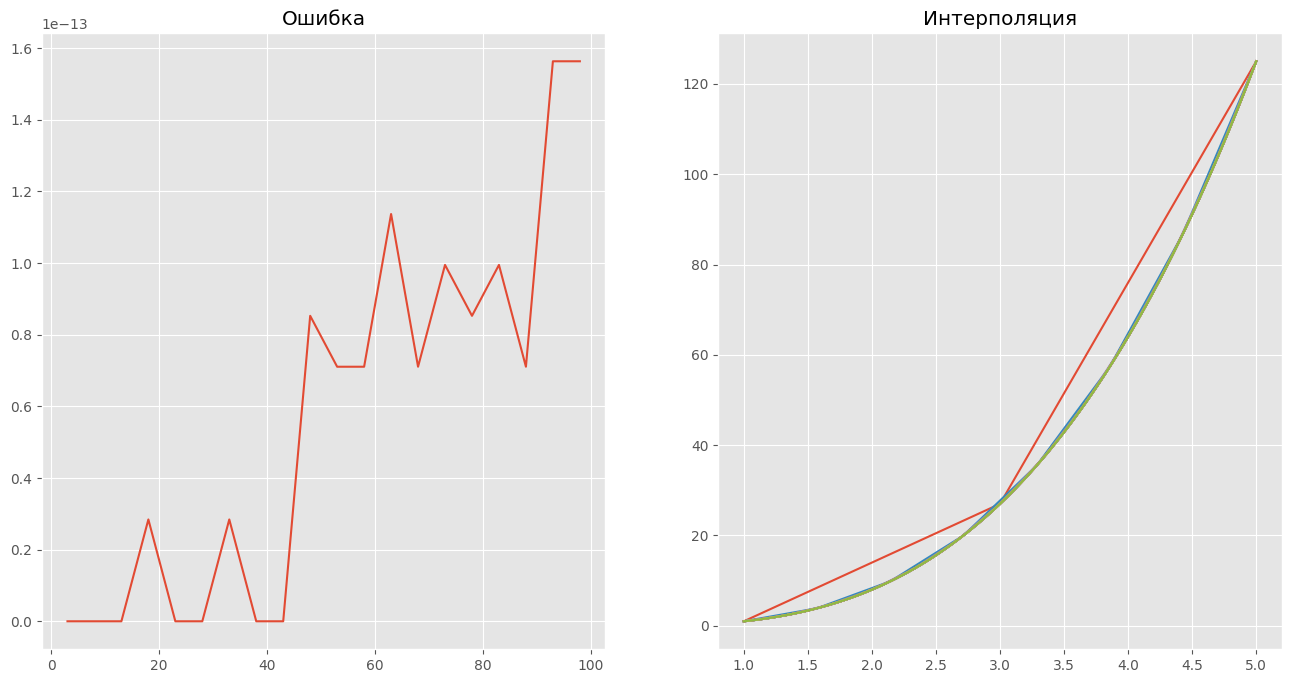

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
f = lambda x: x**3

x_max, x_min, step = 100, 3, 5

N_x = np.arange(x_min, x_max, step, dtype=int)
ERROR = []
for n_x in N_x:
    x = np.linspace(1, 5, n_x)
    basis = [create_sin_basis(k) for k in range(1, x.shape[0]+1)]
    pl = interpolate(x, f(x))
    axes[1].plot(x, pl(x))
    ERROR.append(error(f, pl, x))

axes[1].set_title("Интерполяция")
axes[0].set_title("Ошибка")
axes[0].plot(N_x, ERROR);
# axes[0].set_yscale('log')

## Интерполяция куба полиномами

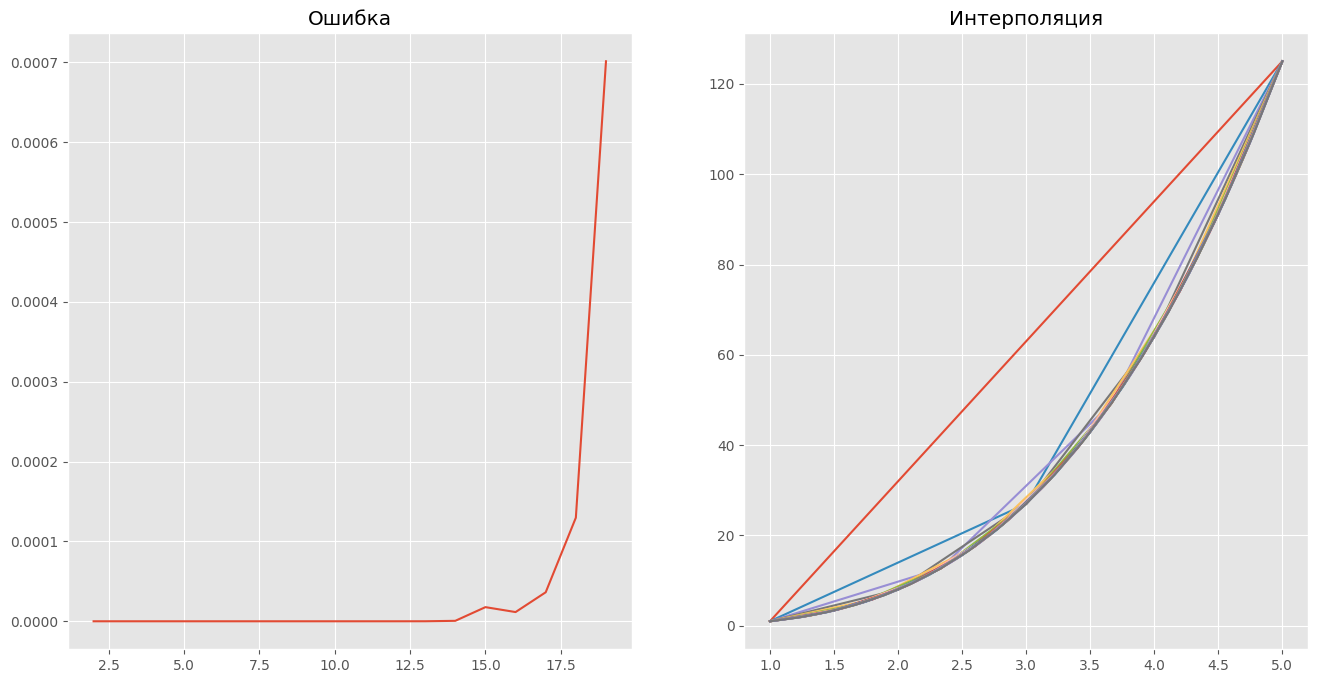

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
f = lambda x: x**3

# Больше 25 уже выдает бред
x_max, x_min, step = 20, 2, 1

N_x = np.arange(x_min, x_max, step, dtype=int)
ERROR = []
for n_x in N_x:
    x = np.linspace(1, 5, n_x)
    basis = [create_sin_basis(k) for k in range(1, x.shape[0]+1)]
    pl = interpolate(x, f(x), basis=basis)
    axes[1].plot(x, pl(x))
    ERROR.append(error(f, pl, x))

axes[1].set_title("Интерполяция")
axes[0].set_title("Ошибка")
axes[0].plot(N_x, ERROR);
# axes[0].set_yscale('log')

## Интерполяционный многочлен Лагранжа

In [ ]:
# Интерполяционный многочлен Лагранжа
def Lagrange_polynomial(f, x_array):

    def l_p(x):
        L_p = 0
        for k in range(x_array.shape[0]):
            tmp = 1
            for i in range(x_array.shape[0]):
                if(i != k):
                    tmp *= (x - x_array[i]) / (x_array[k] - x_array[i])
            L_p += f[k] * tmp

        return L_p
    return l_p

## Интерполяция куба многочленом Лагранжа

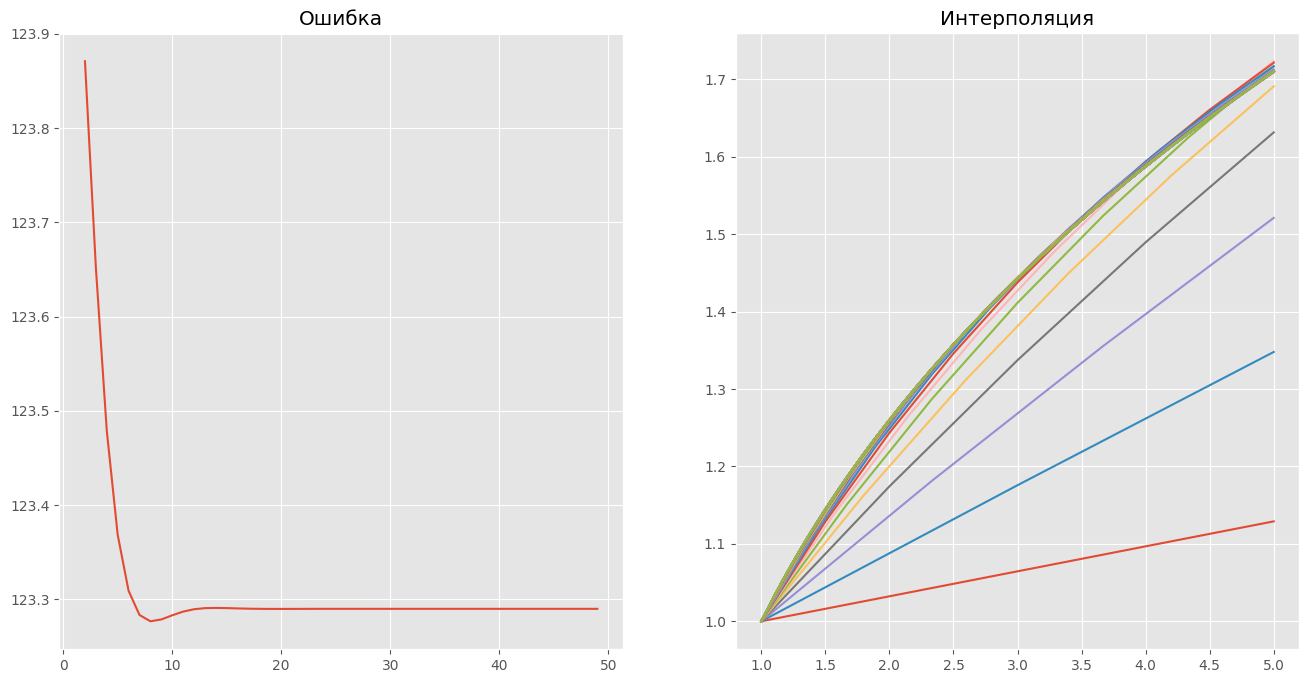

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

f = lambda x: x**3

x_max, x_min, step = 50, 2, 1

N_x = np.arange(x_min, x_max, step, dtype=int)
ERROR = []
for n_x in N_x:
    x = np.linspace(1, 5, n_x)
    l_p = Lagrange_polynomial(x, f(x))
    axes[1].plot(x, l_p(x))
    ERROR.append(error(f, l_p, x))

axes[1].set_title("Интерполяция")
axes[0].set_title("Ошибка")
axes[0].plot(N_x, ERROR);
# axes[0].set_yscale('log')